In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import os
import trackml
import time
from numba import jit
from trackml.dataset import load_event , load_dataset
from trackml.score import score_event
from scipy.spatial import distance


### Importing data

In [2]:
hits_train_100, cells_train_100, particles_train_100, truth_train_100 = load_event('train_100_events/event000001000')
data_detectors = pd.read_csv(r"detectors.csv")

#print(data_detectors.iloc[:,:1])
#print(truth_train_100[0:4])

In [3]:
def func_import_100_sample():
    event_id_10 = np.linspace(0,9,10)
    event_id_100 = np.linspace(10,99,90)

    cells_all = []
    hits_all = []
    particles_all = []
    truth_all = []

    for i in range(len(event_id_10)):
        cells_all.append(pd.read_csv('train_100_events/event00000100%d-cells.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        cells_all.append(pd.read_csv('train_100_events/event0000010%d-cells.csv' % event_id_100[i]))

    for i in range(len(event_id_10)):
        hits_all.append(pd.read_csv('train_100_events/event00000100%d-hits.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        hits_all.append(pd.read_csv('train_100_events/event0000010%d-hits.csv' % event_id_100[i]))

    for i in range(len(event_id_10)):
        particles_all.append(pd.read_csv('train_100_events/event00000100%d-particles.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        particles_all.append(pd.read_csv('train_100_events/event0000010%d-particles.csv' % event_id_100[i]))

    for i in range(len(event_id_10)):
        truth_all.append(pd.read_csv('train_100_events/event00000100%d-truth.csv' % event_id_10[i]))
    for i in range(len(event_id_100)):
        truth_all.append(pd.read_csv('train_100_events/event0000010%d-truth.csv' % event_id_100[i]))
    return cells_all , hits_all , particles_all , truth_all


In [4]:
# start = time.time()

# cells_all = func_import_100_sample()[0]
# hits_all = func_import_100_sample()[1]
# particles_all = func_import_100_sample()[2]
# truth_all = func_import_100_sample()[3]

# end = time.time()
# run_time = end - start
# print(run_time, "s")

### Making functions

In [5]:
def func_cleaning_data(cells , hits, particles , truth):
    #Finding all hit_id that is noice, to use in other files for removing nocie in them.
    def noice(truth):
        truth_hit_id_noice = [truth.hit_id[i] for i in range(len(truth)) if truth.particle_id[i] == 0]
        return truth_hit_id_noice
    truth_hit_id_noice_list = noice(truth)
    #Removing all the noice in the truth file:
    truth_zero_noice = truth.drop(truth.index[truth['particle_id'] == 0]).reset_index()
    #Removing all the data where the nhits is >=3 :
    particles_zero_noice = particles.drop(particles.index[particles['nhits'] <= 3]).reset_index()
    particles_zero_noice_sorted_unique = particles_zero_noice.sort_values(by = "particle_id",ascending=True)
  
    
    
    #Making a function that can remove all the hit_id that was seen as noice in the truth fil. Used in the hits and cells files.
    def FRBV(file_name, column_name, list_of_values): # filter a row by a value or a list of values
        return file_name[~file_name[column_name].isin(list_of_values)]
    
    #Making a function that can make a list of the hit_ids that has a weight of 0.
    def weight_equle_0(data):
        data = [data.hit_id[i] for i in range(len(data)) if data.weight[i] == 0]
        return data
    

    #Removing all the noice in the cells file:
    cells_zero_noice = FRBV(cells , "hit_id" , truth_hit_id_noice_list).reset_index()
    #Removing all the noice in the hits file:
    hits_zero_noice = FRBV(hits , "hit_id" , truth_hit_id_noice_list).reset_index()
    
    #Sorts the truth and particle data
    truth_zero_noice_sorted = truth_zero_noice.sort_values(by = "particle_id",ascending=True)
    truth_zero_noice_sorted_unique = np.unique(truth_zero_noice_sorted.particle_id)

    
    #Removes all the data in particle file, where there is no nhits = 0,  that has a nhits over 7.
    def nhit_over_7(data):
        data = [data.particle_id[i] for i in range(len(data)) if data.nhits[i] > 7]
        return data
    
    #Removing all the data where nhits is less then 7
    particle_id_with_nhits_over_7 = nhit_over_7(particles_zero_noice_sorted_unique)
    
    #Removing all the data where nhits is over then 7
    particle_id_with_nhits_lees_7 = FRBV(particles_zero_noice_sorted_unique , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    
    #Removing all the data where a particle_id has more then 7 nhits.
    truth_zero_noice_sorted_with_nhits_lees_7 = FRBV(truth_zero_noice_sorted , "particle_id" , particle_id_with_nhits_over_7).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    
    truth_weight_0_list = weight_equle_0(truth_zero_noice_sorted_with_nhits_lees_7)
    
    truth_zero_noice_sorted_with_nhits_lees_7_weight_0 = FRBV(truth_zero_noice_sorted_with_nhits_lees_7,"hit_id",truth_weight_0_list).reset_index().drop("index",axis = 1)
    
    
    
    #Removing the data where the particle_id has less then 7 nhits.
    truth_zero_noice_sorted_with_nhits_over_7 = FRBV(truth_zero_noice_sorted , "particle_id" ,truth_zero_noice_sorted_with_nhits_lees_7.particle_id).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    
    

    #Removing the data where the hit_id has less the 7 nhits.
    hits_zero_noice_sorted_with_nhits_lees_7 = FRBV(hits_zero_noice, "hit_id",truth_zero_noice_sorted_with_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    
    
    #Removing the data where the hit_id has less the 7 nhits.
    cells_zero_noice_sorted_with_nhits_lees_7 = FRBV(cells_zero_noice, "hit_id",truth_zero_noice_sorted_with_nhits_over_7["hit_id"]).drop("index",axis = 1).reset_index().drop("index",axis = 1)
    
    particles_id_over_3 = [particles.particle_id[i] for i in range(len(particles)) if particles.nhits[i] >= 3]

    truth_zero_noice_over_3 = FRBV(truth_zero_noice,"particle_id",particles_id_over_3).drop("index",axis = 1).reset_index().drop("index",axis = 1)

    hits_zero_noice_sorted_with_nhits_lees_7_over_3_with_weight_0 = FRBV(hits_zero_noice_sorted_with_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)

    hit_id_in_hits_but_not_in_truth = FRBV(hits_zero_noice_sorted_with_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_sorted_with_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)

    hits_zero_noice_sorted_with_nhits_lees_7_over_3_without_weight_0 = FRBV(hits_zero_noice_sorted_with_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_hits_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)
    
    cells_zero_noice_sorted_with_nhits_lees_7_over_3_with_weight_0 = FRBV(cells_zero_noice_sorted_with_nhits_lees_7,"hit_id",truth_zero_noice_over_3.hit_id).reset_index().drop("index",axis = 1)

    hit_id_in_cells_but_not_in_truth = FRBV(cells_zero_noice_sorted_with_nhits_lees_7_over_3_with_weight_0,"hit_id",truth_zero_noice_sorted_with_nhits_lees_7_weight_0.hit_id).reset_index().drop("index",axis = 1)


    cells_zero_noice_sorted_with_nhits_lees_7_over_3_without_weight_0 = FRBV(cells_zero_noice_sorted_with_nhits_lees_7_over_3_with_weight_0,"hit_id",hit_id_in_cells_but_not_in_truth.hit_id).reset_index().drop("index",axis = 1)
    
    return cells_zero_noice_sorted_with_nhits_lees_7_over_3_without_weight_0 , hits_zero_noice_sorted_with_nhits_lees_7_over_3_without_weight_0 , particle_id_with_nhits_lees_7 , truth_zero_noice_sorted_with_nhits_lees_7_weight_0

In [6]:
cells , hits , particles, truth = func_cleaning_data(cells_train_100,hits_train_100,particles_train_100,truth_train_100)

### Calling data cleaning data

In [7]:
Start = time.time()

print("Lenght of particle_id_with_nhits_lees_7 " ,len(particles))
print("Lenght of truth_zero_noice_sorted_with_nhits_lees_7 " , len(truth))
print("Lenght of hits_zero_noice_sorted_with_nhits_lees_7 " ,len(hits))
print("Lenght of cellszero_noice_sorted_with_nhits_lees_7 " ,len(cells))

print("Truth = ", min(truth["hit_id"]),max(truth["hit_id"])) 
print("Hits = ", min(hits["hit_id"]),max(hits["hit_id"])) 
print("Cells = ", min(cells["hit_id"]),max(cells["hit_id"]))

print("Weight = ", min(truth["weight"]),max(truth["weight"])) 

end = time.time()
run_time = end - Start
print(run_time, "s")

Lenght of particle_id_with_nhits_lees_7  1323
Lenght of truth_zero_noice_sorted_with_nhits_lees_7  7265
Lenght of hits_zero_noice_sorted_with_nhits_lees_7  7265
Lenght of cellszero_noice_sorted_with_nhits_lees_7  56883
Truth =  206 120901
Hits =  206 120901
Cells =  206 120901
Weight =  6.1936698330100626e-06 0.00016544699610676616
0.011967182159423828 s


In [8]:
truth.to_csv("truth_clean")

In [9]:
def FRBV(file_name, column_name, list_of_values): # filter a row by a value or a list of values
    return file_name[~file_name[column_name].isin(list_of_values)]
print(FRBV(truth,"hit_id",hits.hit_id))

Empty DataFrame
Columns: [hit_id, particle_id, tx, ty, tz, tpx, tpy, tpz, weight]
Index: []


In [10]:
Start = time.time()

#for i in range(100):
#    cells_all_clean , hits_all_clean , particles_all_clean, truth_all_clean  = func_cleaning_data(cells_all[i],hits_all[i],particles_all[i],truth_all[i])

end = time.time()
run_time = end - Start
print(run_time, "s")

0.0 s


In [16]:
Start = time.time()

def car_to_cyl_cood(x,y,z):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    z = z
    return r , phi , z 


car_to_cyl_cood(hits.x,hits.y,hits.z)

r_hits , phi_hits , z_hits = car_to_cyl_cood(hits.x,hits.y,hits.z)
r_truth , phi_truth , z_truth = car_to_cyl_cood(truth.tx,truth.ty,truth.tz)



end = time.time()
run_time = end - Start
print(run_time, "s")

0.0029616355895996094 s


### Kigger på data

### Ploting data pre GNN

In [12]:
def plotting_data(data_rough,data_clean):
    XYZ_rough = [[],[],[]]
    XYZ_clean = [[],[],[]]
    for i, idx in enumerate(range(len(data_rough.x))):
        if abs(data_rough.z[i]) < 2000:
            XYZ_rough[0].append((data_rough.x[idx]))
            XYZ_rough[1].append((data_rough.y[idx]))
            XYZ_rough[2].append((data_rough.z[idx]))
    print(len(XYZ_rough[0]), len(XYZ_rough[1]), len(XYZ_rough[2]))

    for i, idx in enumerate(range(len(data_clean.x))):
        if abs(data_clean.z[i]) < 2000:
            XYZ_clean[0].append((data_clean.x[idx]))
            XYZ_clean[1].append((data_clean.y[idx]))
            XYZ_clean[2].append((data_clean.z[idx]))
    print(len(XYZ_clean[0]), len(XYZ_clean[1]), len(XYZ_clean[2]))
    return XYZ_rough , XYZ_clean

XYZ_rough , XYZ_clean = plotting_data(hits_train_100,hits)

110919 110919 110919
7081 7081 7081


(-2000.0, 2000.0)

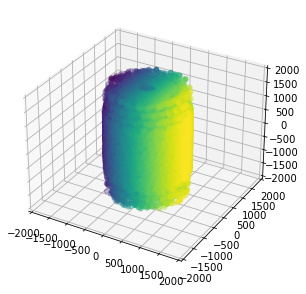

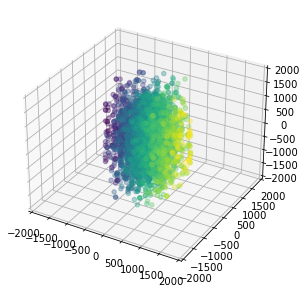

In [13]:
zoom = 2000
figsize = 5
alpha = 0.35

fig = plt.figure(1, figsize = (figsize,figsize))
ax = plt.axes(projection='3d')
ax.scatter3D(XYZ_rough[0],XYZ_rough[1],XYZ_rough[2], c = XYZ_rough[0], alpha = alpha)
plt.xlim(-zoom,zoom)
plt.ylim(-zoom,zoom)
ax.set_zlim(-zoom,zoom)


fig = plt.figure(2, figsize = (figsize,figsize))
ax = plt.axes(projection='3d')
ax.scatter3D(XYZ_clean[0],XYZ_clean[1],XYZ_clean[2], c = XYZ_clean[0] , alpha = alpha)
plt.xlim(-zoom,zoom)
plt.ylim(-zoom,zoom)
ax.set_zlim(-zoom,zoom)

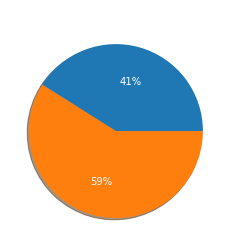

In [14]:
plt.figure(1)
plt.pie(particles.groupby('q')['vx'].count(), labels=['negative', 'positive'],autopct='%.0f%%',shadow=True, radius=1,textprops=dict(color="w"))
plt.title('Distribution of particle charges:',color = "white")
plt.show()

### Looking at the detector

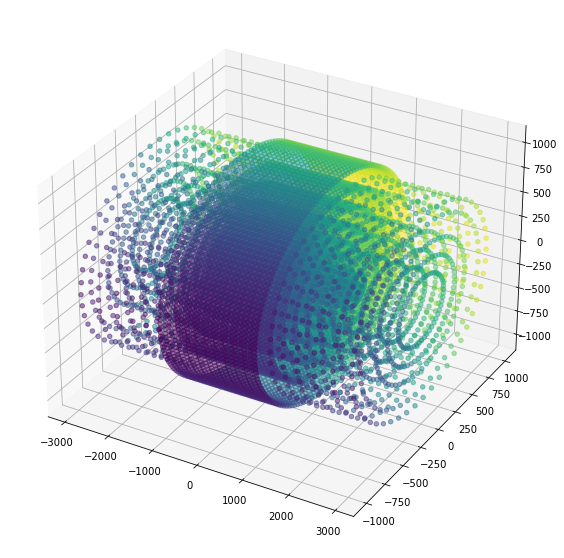

In [15]:
x = data_detectors.cx
y = data_detectors.cy
z = data_detectors.cz
fig = plt.figure(5, figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(z , y ,x, c = y, alpha = 0.5)